In [1]:
# solution 1:

import numpy as np

beta=0.442
delta=0.6415
sigma=3
A=1
alpha=0.35
nvec=np.array([1,1,0.2])


def get_K(bvec):
    K = np.sum(bvec)
    return K

def get_L(nvec):
    L = np.sum(nvec)
    return L

def get_w(alpha, A, K, L):
    w= (1- alpha)*A*(K/L)**alpha
    return w

def get_r(alpha, A, K, L, delta):
    r = (alpha*A*(L/K)**(1-alpha))-delta
    return r

def get_c(nvec, bvec, alpha,A, delta):
    K = get_K(bvec)
    L = get_L(nvec)
    r = get_r(alpha,A,K,L, delta)
    w = get_w(alpha,A,K,L)
    bvec_t=np.append(0,bvec) #intital savings to begin with are are zero
    bvec_tp1=np.append(bvec,0) # last period savings are zero too
    c= nvec*w + (1+r)*bvec_t - bvec_tp1
    return c

def MU_c(c, sigma):
    MU = c**(-sigma)
    return MU

def feasible(f_params, bvec_guess):
    K = get_K(bvec_guess)
    cvec = get_c(nvec, bvec_guess, alpha, A, delta)
    K_constr = K <= 0 
    c_constr = cvec <= 0
    b_constr = np.zeros(2, dtype=bool)
    if c_constr[0]==True:
        b_constr[0]=True
    if c_constr[1]==True:
        b_constr[0]=True
        b_constr[1]=True
    if c_constr[2]==True:
        b_constr[2]=True
    return b_constr, c_constr, K_constr


f_params=(nvec, A, alpha, delta)
bvec_guess = np.array([0.1,0.1])
print('The b_const, c_constr, K_constr for bvec_guess=[1.0, 1.2] are:',  feasible(f_params,np.array([1.0,1.2])))    
print('The b_const, c_constr, K_constr for bvec_guess=[0.06, -0.001] are: ', feasible(f_params,np.array([0.06, -0.001])))
print('The b_const, c_constr, K_constr for bvec_guess=[0.1, 0.1] are: ', feasible(f_params,np.array([0.1, 0.1])))



The b_const, c_constr, K_constr for bvec_guess=[1.0, 1.2] are: (array([ True, False]), array([ True, False, False]), False)
The b_const, c_constr, K_constr for bvec_guess=[0.06, -0.001] are:  (array([False, False]), array([False, False, False]), False)
The b_const, c_constr, K_constr for bvec_guess=[0.1, 0.1] are:  (array([False, False]), array([False, False, False]), False)


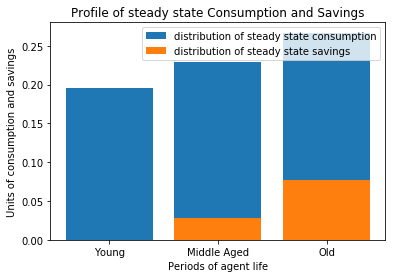

{'b_ss': array([0.02817692, 0.07686545]), 'c_ss': array([0.19597528, 0.22861594, 0.26669307]), 'w_ss': 0.22415219593446262, 'r_ss': 1.8863765057190751, 'K_ss': 0.10504237022597476, 'Y_ss': 0.7586689708551043, 'C_ss': 0.6912842903551415, 'EulErr_ss': array([-2.84217094e-14,  2.84217094e-14]), 'RCerr_ss': 1.3877787807814457e-17, 'ss_time': 0.0026922643692728343}


In [4]:
#solution 2

import scipy.optimize as opt
import numpy as np
from matplotlib import pyplot as plt
import time

beta=0.55
delta=0.6415
sigma=3
A=1
alpha=0.35
nvec=np.array([1,1,0.2])
SS_tol=1e-14


def get_K(bvec):
    K = np.sum(bvec)
    return K

def get_L(nvec):
    L = np.sum(nvec)
    return L

def get_w(alpha, A, K, L):
    w= (1- alpha)*A*(K/L)**alpha
    return w

def get_r(alpha, A, K, L, delta):
    r = (alpha*A*(L/K)**(1-alpha))-delta
    return r

def get_c(nvec, bvec, alpha,A, delta):
    K = get_K(bvec)
    L = get_L(nvec)
    r = get_r(alpha,A,K,L, delta)
    w = get_w(alpha,A,K,L)
    bvec_t=np.append(0,bvec) # initital savings is zero
    bvec_tp1=np.append(bvec,0) #last period everything is consumed
    c= nvec*w + (1+r)*bvec_t - bvec_tp1
    return c

def MU_c(c, sigma):
    MU= c**(-sigma)
    return MU

def euler_errors(bvec, alpha,A,beta, nvec, delta, sigma):
    K = get_K(bvec)
    L = get_L(nvec)
    r = get_r(alpha, A, K,L,delta)
    cvec = get_c(nvec, bvec, alpha,A, delta)
    u_prime = MU_c(cvec, sigma)
    r = get_r(alpha,A,K,L,delta)
    errors = u_prime[:-1] - beta*(1+r)*u_prime[1:]
    return errors

def get_ss(params, bvec_guess, SS_graphs):
    start_time= time.clock()
    euler_args = (alpha,A,beta,nvec, delta, sigma)
    results = opt.root(euler_errors, bvec_guess, args=euler_args, tol=SS_tol)
    b_ss = results.x
    EulErr_ss = results.fun
    c_ss = get_c(nvec, b_ss,alpha,A,delta)
    K_ss = get_K(b_ss)
    L_ss = get_L(nvec)
    w_ss = get_w(alpha, A, K_ss, L_ss)
    r_ss = get_r(alpha, A, K_ss, L_ss, delta)
    Y_ss = A*((K_ss)**alpha)*(L_ss**(1-alpha))
    C_ss = np.sum(c_ss)
    f_params = (nvec,A,alpha,delta)
    res_constraint = feasible(f_params,b_ss)
    RCerr_ss = Y_ss - C_ss - delta*K_ss
    ss_time = time.clock() - start_time
    if SS_graphs==True:
        plt.bar(['Young', 'Middle Aged', 'Old'], c_ss, label='distribution of steady state consumption')
        plt.bar(['Middle Aged', 'Old'], b_ss, label='distribution of steady state savings')
        plt.legend()
        plt.title('Profile of steady state Consumption and Savings')
        plt.xlabel('Periods of agent life')
        plt.ylabel('Units of consumption and savings')
        plt.show()    
    ss_output = {'b_ss': b_ss, 'c_ss': c_ss, 'w_ss': w_ss, 'r_ss': r_ss, 'K_ss': K_ss,
                 'Y_ss':Y_ss, 'C_ss':C_ss, 'EulErr_ss': EulErr_ss, 'RCerr_ss': RCerr_ss,
                'ss_time': ss_time}
    return ss_output

params=((beta, sigma, nvec, A, alpha, delta, SS_tol))
bvec_guess = np.array([0.1,0.1])
SS_graphs = False
ss_output= get_ss(params, bvec_guess, True)
print(ss_output)



As  β increases, interest rate goes down. This is because people are now more patient and hence want to save more for their old age as they value old age consumption more. Thus there will be more savings and hence capital stock floating around in the economy. This will drive the interest rate down. Wages will correspondingly inrease and this is indeed the case. This leads to an income effect in the hands of the young and middle aged who increase consumption. Consumption in each period of life is higher when  β  is higher. Finally, we see that savings are lower when young but higher when middle aged when  β  increases.

C:\Users\hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars


The maximum Euler Error is:  5.2703455821756506e-08


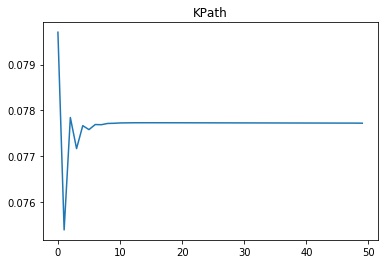

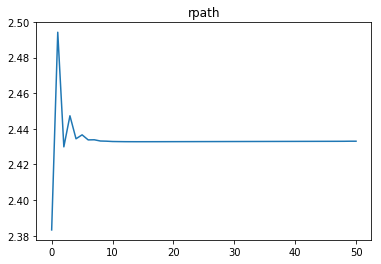

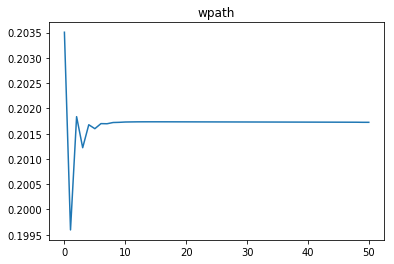

In [8]:
#solution 3

import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
from itertools import chain

beta=0.442
delta=0.6415
sigma=3
A=1
alpha=0.35
nvec=np.array([1,1,0.2])
SS_tol=1e-14
T=50
iter_max=100 
xi = 0.5

def get_K(bvec):
    K = bvec.sum()
    return K


def get_L(nvec):
    L = nvec.sum()
    return L


def get_r(nvec, bvec, A, alpha, delta):
    K = get_K(bvec)
    L = get_L(nvec)
    r = alpha * A * (L / K) ** (1 - alpha) - delta
    return r


def get_w(nvec, bvec, A, alpha):
    K = get_K(bvec)
    L = get_L(nvec)
    w = (1 - alpha) * A * (K / L) ** alpha
    return w


def get_c(nvec, bvec, r, w):
    b_s = np.append(0.0, bvec)
    b_splus1 = np.append(bvec, 0.0)
    cvec = (1 + r) * b_s + w * nvec - b_splus1
    return cvec


def u_prime(cvec, sigma):
    MUc = cvec ** -sigma
    return MUc


def euler_system(bvec, *args):
    (nvec, beta, sigma, A, alpha, delta) = args
    r = get_r(nvec, bvec, A, alpha, delta)
    w = get_w(nvec, bvec, A, alpha)
    cvec = get_c(nvec, bvec, r, w)
    euler_errors = (u_prime(cvec[:2], sigma) - beta * (1+r) *
                    u_prime(cvec[1:], sigma))
    return euler_errors


def lone_euler(b32, *args):
    (r1, r2, w1, w2, nvec, b21, beta, sigma) = args
    c21 = (1 + r1) * b21 + w1 * nvec[1] - b32
    c32 = (1 + r2) * b32 + w2 * nvec[2]
    euler_error = (u_prime(c21, sigma) - beta * (1 + r2) *
                   u_prime(c32, sigma))
    return euler_error

    
def euler_sys_tpi(guesses, *args):
    b2, b3 = guesses
    (r_tp1, r_tp2, w_t, w_tp1, w_tp2, nvec, beta, sigma) = args
    c1 = w_t * nvec[0] - b2
    c2 = (1 + r_tp1) * b2 + w_tp1 * nvec[1] - b3
    c3 = (1 + r_tp2) * b3 + w_tp2 * nvec[2]
    agg_c = c1+c2+c3
    euler_error1 = (u_prime(c1, sigma) - beta * (1 + r_tp1) *
                    u_prime(c2, sigma))
    euler_error2 = (u_prime(c2, sigma) - beta * (1 + r_tp2) *
                    u_prime(c3, sigma))
    euler_errors = [euler_error1, euler_error2]
    return euler_errors


def get_r_path(L, K, A, alpha, delta):
    rpath = alpha * A * (L / K) ** (1 - alpha) - delta
    return rpath


def get_w_path(L, K, A, alpha):
    wpath = (1 - alpha) * A * (K / L) ** alpha
    return wpath

bvec_init = np.array([0.5, 0.5])
eul_args = (nvec, beta, sigma, A, alpha, delta)
results = opt.root(euler_system, bvec_init, args=(eul_args), tol=1e-14)
b_ss = results.x
zero_val = results.fun
r_ss = get_r(nvec, b_ss, A, alpha, delta)
w_ss = get_w(nvec, b_ss, A, alpha)
K_ss = get_K(b_ss)
L_ss = get_L(nvec)

bvec1 = np.array([0.8 * b_ss[0], 1.1 * b_ss[1]])
T = 50
xi = 0.2
K1 = get_K(bvec1)
Kpath = np.linspace(K1, K_ss, num=T)

error_euler=[]
dist = 10
tpi_iter = 0
tpi_max_iter = 100
tpi_tol = 1e-9
while (dist > tpi_tol) & (tpi_iter < tpi_max_iter):
    tpi_iter += 1
    L = get_L(nvec)
    rpath = get_r_path(L, Kpath, A, alpha, delta)
    rpath = np.append(rpath, r_ss)
    wpath = get_w_path(L, Kpath, A, alpha)
    wpath = np.append(wpath, w_ss)
    b32_guess = bvec1[1]
    b32_args = (rpath[0], rpath[1], wpath[0], wpath[1], nvec, bvec1[0],
                beta, sigma)
    results = opt.root(lone_euler, b32_guess, args=(b32_args))
    b32 = results.x
    lone_euler_error=results.fun
    error_euler.append(lone_euler_error.tolist())
    bmat = np.zeros((T+1, 2))
    bmat[0, :] = bvec1
    bmat[1, 1] = b32
    for t in range(1, T):
        bguess = [bmat[t, 0], bmat[t-1, 1]]
        b_args = (rpath[t], rpath[t+1], wpath[t-1], wpath[t],
                  wpath[t], nvec, beta, sigma)
        results = opt.root(euler_sys_tpi, bguess, args=(b_args))
        b2, b3 = results.x
        euler_errors = results.fun
        error_euler.append(euler_errors.tolist())
        bmat[t, 0] = b2
        bmat[t+1, 1] = b3
    Kprime = bmat.sum(axis=1)
    dist = ((Kpath[:-1] - Kprime[:-2]) ** 2).sum()
    Kpath = xi * Kprime[:-2] + (1 - xi) * Kpath[:-1]
    Kpath = np.append(Kpath, K_ss)
Lpath = np.ones(len(Kpath))*2.2   
Ypath = A*((Kpath)**alpha)*(Lpath)**(1-alpha)


merged = list(chain(*error_euler))
print('The maximum Euler Error is: ', max(np.abs(np.array(merged))))

plt.plot(Kpath)
plt.title('KPath')
plt.show()

plt.plot(rpath)
plt.title('rpath')
plt.show()

plt.plot(wpath)
plt.title('wpath')
plt.show()

